In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
from CASutils import averaging_utils as avg

In [2]:
plotpath="/project/cas/islas/python_plots/CAM7_vertres_paper/FIGURES/SUPP/"

In [3]:
era5 = xr.open_dataset("/project/cas/islas/python_savs/CAM7_vertres_paper/grids/reanalyses/ERA5_hybridcoefs.nc")
jra55 = xr.open_dataset("/project/cas/islas/python_savs/CAM7_vertres_paper/grids/reanalyses/JRA55_hybridcoefs.nc")
merra2 = xr.open_dataset("/project/cas/islas/python_savs/CAM7_vertres_paper/grids/reanalyses/MERRA2_pmid.nc")

### Compute mid and half pressure levels for ERA5 hybrid coefficients

In [4]:
phalf_era5 = (era5.a_half + era5.b_half*1e5)/100.
pmid_era5 = (era5.a_model + era5.b_model*1e5)/100.

### Compute mid and half levels for JRA55 hybrid coefficients

In [5]:
phalf_jra55 = (jra55.hyam + jra55.hybm*1e5)/100.
pmid_jra55 = phalf_jra55[0:phalf_jra55.lev.size] - (phalf_jra55[0:phalf_jra55.lev.size] - phalf_jra55[1:phalf_jra55.lev.size+1])
phalf_jra55 = phalf_jra55.reindex(lev=list(reversed(phalf_jra55.lev)))
pmid_jra55 = pmid_jra55.reindex(lev=list(reversed(pmid_jra55.lev)))

### Compute mid and half levels for MERRA5 (from pressures, globally averaged)

In [6]:
merra2_delp = avg.cosweightlonlat(merra2.DELP.isel(time=0),0,360,-90,90)
merra2_pl = avg.cosweightlonlat(merra2.PL.isel(time=0), 0, 360, -90, 90)
phalf_merra2 = [merra2_pl.isel(lev=0) - merra2_delp.isel(lev=0)/2.]
for i in np.arange(0,merra2_delp.lev.size,1):
    phalf_merra2.append( merra2_pl.isel(lev=i) + merra2_delp.isel(lev=i)/2. )
phalf_merra2 = xr.concat(phalf_merra2, dim='ilev')
pmid_merra2 = merra2_pl/100.
phalf_merra2 = phalf_merra2/100.

flipping longitudes
flipping longitudes


In [7]:
def calcdz(p, levvar='ilev'):
    H=7000.
    z=-H*np.log(p/1000.)
    dz = -1.*(np.array(z.isel(**{levvar:slice(1,p.size)}) - np.array(z.isel(**{levvar:slice(0,p.size-1)}))))
    return dz

### Set up the plot

In [8]:
def setupplot(x1, x2, y1, y2, titlestr, xlim=None):
    H=7000.
    ax = fig.add_axes([x1, y1, x2-x1, y2-y1])
    ax.set_ylim(-np.log(1000),-np.log(1e-6))
    if (xlim):
        ax.set_xlim(0,xlim)
        ax.set_xticks( (np.arange(0,xlim/500+1,1)*500).astype(int).tolist())
        ax.set_xticklabels( (np.arange(0,xlim/500+1,1)*500).astype(int).tolist(), fontsize=13)
    else:
        ax.set_xlim(0,5800)
        ax.set_xticks(np.arange(0,5500/1000+1,1)*1000)
        ax.set_xticklabels( (np.arange(0,5500/1000+1,1)*1000).astype(int).tolist(), fontsize=13)
        
    ax.set_yticks([-np.log(1000),-np.log(100),-np.log(10),-np.log(1),-np.log(0.1),
                   -np.log(0.01),-np.log(0.001),-np.log(0.0001),-np.log(0.00001),-np.log(0.000001)])
    ax.set_yticklabels(['1000','100','10','1','0.1','1e-2','1e-3','1e-4','1e-5','1e-6'], fontsize=13)
    ax.set_ylabel('Pressure (hPa)', fontsize=14)
    
    ax2 = ax.twinx()
    ax2.set_ylim(-np.log(1000),-np.log(1e-6))
    
    zticks=[0,20,40,60,80,100,120,140]
    ztickvals = [1000.*np.exp(-zticks[i]*1000./H) for i in np.arange(0,len(zticks),1)]
    ax2.set_yticks(-np.log(ztickvals))
    ax2.set_yticklabels(['0','20','40','60','80','100','120','140'], fontsize=13)
    ax2.set_ylabel('Height (km)', fontsize=14)
    
    ax.set_title(titlestr,fontsize=16)
    ax.set_xlabel('dz (m)', fontsize=14)
    
    return ax

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


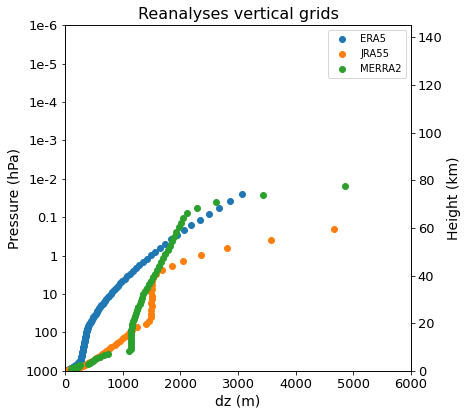

In [9]:
fig = plt.figure(figsize=(16,16))

ax = setupplot(0.02,0.32,0.7,1,'Reanalyses vertical grids')

dz_era5 = calcdz(phalf_era5, levvar='half_level')
ax.plot(dz_era5, -np.log(pmid_era5),"o", label='ERA5')

dz_jra55 = calcdz(phalf_jra55, levvar='lev')
ax.plot(dz_jra55, -np.log(pmid_jra55),"o", label='JRA55')

dz_merra2 = calcdz(phalf_merra2, levvar='ilev')
ax.plot(dz_merra2, -np.log(pmid_merra2),"o", label='MERRA2')

ax.legend()

fig.savefig(plotpath+'figS2.pdf', bbox_inches='tight', facecolor='white')